## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-02-16 22:53:07.538628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 22:53:07.538664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 22:53:07.569373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 22:53:07.638802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-16 22:53:08.626204: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-02-16 22:53:12.007439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-16 22:53:12.138142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-16 22:53:12.141027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [2]:


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table




# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign/benign_2312_HTML.parquet', 
    'parkets/benign/umbrella_benign_FINISHED_HTML.parquet'
]
malicious_dataset_filenames = [
    'parkets/malware_2406_strict_HTML.parquet'
]

# lex-dga-830k-pick.parquet LABEL je jmeno rodiny
#  'parkets/malware_2406_strict_HTML.parquet'


# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

# print labels from malicious datasets


# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
#df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


In [3]:


subsample = 0.02 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample, random_state=42)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)


    
print(f"Total features: {len(df.columns)}")
print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



Total features: 264
Total samples: 18343
Benign count: 816324
Malicious count: 100809


### Generate subsets of the training dataset

In [2]:
import pandas as pd

# Define prefixes
prefixes = ["dns_", "tls_", "html_", "geo_", "rdap_", "lex_", "ip_"]

# Dictionary to store filtered datasets
subset_dfs = {}

# Create subsets for each prefix
for prefix in prefixes:
    subset_df = df.loc[:, df.columns.str.startswith(prefix) | df.columns.isin(['label'])]
    
    # Store in dictionary
    subset_dfs[prefix] = subset_df

    print(f"Subset '{prefix}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")
    # print all columns in the subset
    print(subset_df.columns)
    
    
    
## Agregations 

# agregate dns and rdap features and append to prefixes 


NameError: name 'df' is not defined

#### Aggregations

In [5]:
import pandas as pd

# Define your DataFrame
# df = pd.read_csv('your_dataset.csv')

# Define the list of aggregates
aggregates = [
    ["lex_"],  # dns + rdap
    ["lex_", "dns_", "ip_", "tls_", "geo_"],  # tls + geo + ip
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_"],  # html + lex
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_", "html_"]  # all
]


# Process each aggregation group
for group in aggregates:
    # Build a regex pattern to match any of the prefixes in the group
    pattern = '|'.join(f'^{prefix}' for prefix in group)

    # Select columns starting with any of the specified prefixes or the 'label' column
    subset_df = df.loc[:, df.columns.str.contains(pattern) | (df.columns == 'label')]


    # Reset index to turn the 'label' into a column again
    subset_df = subset_df.reset_index()

    # Create a unique key for the aggregated data
    key = '+'.join(group) + "_agg"

    # Store the aggregated DataFrame in the dictionary
    subset_dfs[key] = subset_df


    
# iterate over subsets_df and print the number of benign and malicious samples
for key, subset_df in subset_dfs.items():
    print(f"Subset '{key}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")


Subset 'dns_' contains 41 features and 18343 samples.
Subset 'tls_' contains 25 features and 18343 samples.
Subset 'html_' contains 88 features and 18343 samples.
Subset 'geo_' contains 19 features and 18343 samples.
Subset 'rdap_' contains 25 features and 18343 samples.
Subset 'lex_' contains 63 features and 18343 samples.
Subset 'ip_' contains 9 features and 18343 samples.
Subset 'lex__agg' contains 64 features and 18343 samples.
Subset 'lex_+dns_+ip_+tls_+geo__agg' contains 154 features and 18343 samples.
Subset 'lex_+dns_+ip_+tls_+geo_+rdap__agg' contains 178 features and 18343 samples.
Subset 'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg' contains 265 features and 18343 samples.


### Pycarrect

In [14]:
from pycaret.classification import *
import pandas as pd

# Dictionary to store the top 3 models and results grids for each feature subset
top3_models = {}
results_grids = {}

# Iterate through each subset and train models
for prefix, subset_df in subset_dfs.items():
    print(f"\n🔍 Running model comparison for '{prefix}' features...")

    # PyCaret Setup
    clf = setup(subset_df, target='label', session_id=54, log_experiment=False, experiment_name=f'exp_{prefix}', use_gpu=True, train_size=0.8, index=False)
    
    # Compare models and capture the top 3 models
    top_models = compare_models(sort='F1', n_select=3)
    
    # Store the top 3 models
    top3_models[prefix] = top_models
    
    # Pulling the last model score grid from PyCaret after model comparison
    results_grid = pull()
    results_grids[prefix] = results_grid
    
    # Print information about the top 3 models for the subset
    print(f"✅ Top 3 models for '{prefix}' features:")
    for model in top_models:
        print(model)

# Compile all results into a single DataFrame for comparison
all_results = pd.DataFrame()
for prefix, grid in results_grids.items():
    grid['Subset'] = prefix
    all_results = pd.concat([all_results, grid], axis=0)

# Reset index for a clean look
all_results.reset_index(drop=True, inplace=True)

# Display the consolidated results DataFrame
print("📊 Consolidated Results across all feature subsets:")
display(all_results)



🔍 Running model comparison for 'dns_' features...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Wa

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 41)"
5,Transformed data shape,"(18407, 41)"
6,Transformed train set shape,"(14725, 41)"
7,Transformed test set shape,"(3682, 41)"
8,Numeric features,39
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9182,0.8500,0.9182,0.9101,0.9117,0.5298,0.5406,0.2780
rf,Random Forest Classifier,0.9181,0.8730,0.9181,0.9096,0.9107,0.5215,0.5350,0.6270
xgboost,Extreme Gradient Boosting,0.9189,0.8878,0.9189,0.9104,0.9105,0.5161,0.5343,0.4230
lightgbm,Light Gradient Boosting Machine,0.9210,0.8937,0.9210,0.9144,0.9088,0.4937,0.5318,0.6080
knn,K Neighbors Classifier,0.9104,0.8242,0.9104,0.9015,0.9040,0.4921,0.5002,0.1190
gbc,Gradient Boosting Classifier,0.9119,0.8724,0.9119,0.9022,0.8948,0.4060,0.4559,2.1140
ada,Ada Boost Classifier,0.9044,0.8507,0.9044,0.8897,0.8863,0.3592,0.4019,0.5320
dt,Decision Tree Classifier,0.8848,0.7475,0.8848,0.8847,0.8847,0.4247,0.4249,0.1460
lda,Linear Discriminant Analysis,0.8954,0.7786,0.8954,0.8776,0.8812,0.3465,0.3673,0.1500
ridge,Ridge Classifier,0.8861,0.7792,0.8861,0.8334,0.8368,0.0226,0.0609,0.1100


✅ Top 3 models for 'dns_' features:
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=54, verbose=0,
                     warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
            

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 25)"
5,Transformed data shape,"(18407, 25)"
6,Transformed train set shape,"(14725, 25)"
7,Transformed test set shape,"(3682, 25)"
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8877,0.7187,0.8877,0.8650,0.8385,0.0314,0.0999,0.5450
rf,Random Forest Classifier,0.8876,0.7199,0.8876,0.8626,0.8383,0.0302,0.0962,0.1800
lda,Linear Discriminant Analysis,0.8858,0.6474,0.8858,0.8378,0.8382,0.0333,0.0790,0.1250
et,Extra Trees Classifier,0.8877,0.7196,0.8877,0.8603,0.8381,0.0286,0.0919,0.2000
xgboost,Extreme Gradient Boosting,0.8878,0.7184,0.8878,0.8637,0.8381,0.0289,0.0953,0.2290
knn,K Neighbors Classifier,0.8871,0.5345,0.8871,0.8483,0.8380,0.0290,0.0827,0.1050
gbc,Gradient Boosting Classifier,0.8877,0.7136,0.8877,0.8653,0.8376,0.0250,0.0876,0.4350
dt,Decision Tree Classifier,0.8865,0.7160,0.8865,0.8422,0.8372,0.0244,0.0712,0.0580
ada,Ada Boost Classifier,0.8869,0.6901,0.8869,0.8506,0.8364,0.0181,0.0653,0.2230
qda,Quadratic Discriminant Analysis,0.8870,0.5025,0.8870,0.7868,0.8339,0.0000,0.0000,0.1110


✅ Top 3 models for 'tls_' features:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=54, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=54, verbose=0,
         

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 88)"
5,Transformed data shape,"(18407, 88)"
6,Transformed train set shape,"(14725, 88)"
7,Transformed test set shape,"(3682, 88)"
8,Numeric features,87
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8893,0.6683,0.8893,0.8620,0.8450,0.0762,0.1536,0.2880
xgboost,Extreme Gradient Boosting,0.8888,0.6746,0.8888,0.8597,0.8447,0.0750,0.1492,0.3180
et,Extra Trees Classifier,0.8889,0.6602,0.8889,0.8593,0.8443,0.0720,0.1460,0.2460
lightgbm,Light Gradient Boosting Machine,0.8890,0.6760,0.8890,0.8632,0.8436,0.0665,0.1444,0.6260
knn,K Neighbors Classifier,0.8876,0.6168,0.8876,0.8491,0.8418,0.0556,0.1163,0.1460
gbc,Gradient Boosting Classifier,0.8888,0.6709,0.8888,0.8657,0.8406,0.0450,0.1212,3.3710
ada,Ada Boost Classifier,0.8888,0.6501,0.8888,0.8679,0.8403,0.0431,0.1202,0.8920
dt,Decision Tree Classifier,0.8712,0.6419,0.8712,0.8181,0.8373,0.0595,0.0741,0.1930
lr,Logistic Regression,0.8871,0.6261,0.8871,0.8342,0.8363,0.0166,0.0539,1.4050
ridge,Ridge Classifier,0.8877,0.6352,0.8877,0.8526,0.8363,0.0160,0.0651,0.1490


✅ Top 3 models for 'html_' features:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=54, verbose=0,
                       warm_start=False)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 19)"
5,Transformed data shape,"(18407, 19)"
6,Transformed train set shape,"(14725, 19)"
7,Transformed test set shape,"(3682, 19)"
8,Numeric features,18
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8934,0.8220,0.8934,0.8726,0.8568,0.1551,0.2373,0.2980
xgboost,Extreme Gradient Boosting,0.8945,0.8360,0.8945,0.8800,0.8564,0.1502,0.2451,0.1990
et,Extra Trees Classifier,0.8932,0.8188,0.8932,0.8732,0.8560,0.1498,0.2342,0.2810
lightgbm,Light Gradient Boosting Machine,0.8943,0.8365,0.8943,0.8802,0.8558,0.1460,0.2417,0.5490
dt,Decision Tree Classifier,0.8915,0.8159,0.8915,0.8654,0.8548,0.1449,0.2178,0.0960
knn,K Neighbors Classifier,0.8907,0.7303,0.8907,0.8644,0.8528,0.1317,0.2053,0.1070
gbc,Gradient Boosting Classifier,0.8945,0.8200,0.8945,0.8965,0.8528,0.1229,0.2413,1.6370
ada,Ada Boost Classifier,0.8910,0.8048,0.8910,0.8772,0.8436,0.0630,0.1541,0.5060
dummy,Dummy Classifier,0.8870,0.5000,0.8870,0.7868,0.8339,0.0000,0.0000,0.0430
ridge,Ridge Classifier,0.8869,0.7243,0.8869,0.7868,0.8338,-0.0001,-0.0009,0.1000


✅ Top 3 models for 'geo_' features:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=54, verbose=0,
                       warm_start=False)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,


,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 25)"
5,Transformed data shape,"(18407, 25)"
6,Transformed train set shape,"(14725, 25)"
7,Transformed test set shape,"(3682, 25)"
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9360,0.9435,0.9360,0.9319,0.9296,0.6200,0.6399,0.2820
lightgbm,Light Gradient Boosting Machine,0.9361,0.9433,0.9361,0.9323,0.9293,0.6175,0.6395,0.4880
rf,Random Forest Classifier,0.9311,0.9395,0.9311,0.9263,0.9227,0.5784,0.6048,0.2550
et,Extra Trees Classifier,0.9304,0.9287,0.9304,0.9254,0.9219,0.5739,0.6003,0.2320
gbc,Gradient Boosting Classifier,0.9266,0.9323,0.9266,0.9217,0.9159,0.5355,0.5712,2.2160
dt,Decision Tree Classifier,0.9130,0.8373,0.9130,0.9060,0.9084,0.5215,0.5264,0.1340
ada,Ada Boost Classifier,0.9116,0.9111,0.9116,0.9007,0.8972,0.4271,0.4642,0.5920
knn,K Neighbors Classifier,0.9041,0.8236,0.9041,0.8922,0.8925,0.4144,0.4375,0.1000
lda,Linear Discriminant Analysis,0.8822,0.8554,0.8822,0.8488,0.8565,0.1826,0.2118,0.1280
ridge,Ridge Classifier,0.8886,0.8556,0.8886,0.8647,0.8406,0.0451,0.1187,0.0990


✅ Top 3 models for 'rdap_' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=2

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 63)"
5,Transformed data shape,"(18407, 63)"
6,Transformed train set shape,"(14725, 63)"
7,Transformed test set shape,"(3682, 63)"
8,Numeric features,62
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9159,0.9074,0.9159,0.9061,0.9061,0.4890,0.5097,0.6050
xgboost,Extreme Gradient Boosting,0.9115,0.8962,0.9115,0.9011,0.9029,0.4771,0.4916,0.2780
rf,Random Forest Classifier,0.9071,0.8777,0.9071,0.8940,0.8950,0.4239,0.4468,0.3570
gbc,Gradient Boosting Classifier,0.9095,0.8985,0.9095,0.8972,0.8947,0.4135,0.4487,3.7290
et,Extra Trees Classifier,0.9034,0.8589,0.9034,0.8880,0.8887,0.3831,0.4112,0.3090
ada,Ada Boost Classifier,0.9015,0.8729,0.9015,0.8843,0.8808,0.3227,0.3692,0.9170
dt,Decision Tree Classifier,0.8717,0.6971,0.8717,0.8756,0.8735,0.3780,0.3787,0.2410
knn,K Neighbors Classifier,0.8958,0.7705,0.8958,0.8740,0.8692,0.2461,0.3018,0.1240
lda,Linear Discriminant Analysis,0.8873,0.8306,0.8873,0.8627,0.8681,0.2623,0.2874,0.1790
ridge,Ridge Classifier,0.8898,0.8309,0.8898,0.8661,0.8465,0.0863,0.1683,0.1060


✅ Top 3 models for 'lex_' features:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=54, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 9)"
5,Transformed data shape,"(18407, 9)"
6,Transformed train set shape,"(14725, 9)"
7,Transformed test set shape,"(3682, 9)"
8,Numeric features,8
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8904,0.8346,0.8904,0.8704,0.8755,0.3150,0.3337,0.2120
rf,Random Forest Classifier,0.8901,0.8710,0.8901,0.8702,0.8753,0.3147,0.3329,0.2860
xgboost,Extreme Gradient Boosting,0.9004,0.9076,0.9004,0.8847,0.8752,0.2810,0.3450,0.1790
knn,K Neighbors Classifier,0.8886,0.8244,0.8886,0.8747,0.8750,0.3231,0.3475,3.0490
lightgbm,Light Gradient Boosting Machine,0.9004,0.9069,0.9004,0.8848,0.8748,0.2778,0.3435,0.5950
dt,Decision Tree Classifier,0.8881,0.7951,0.8881,0.8681,0.8738,0.3088,0.3249,0.0780
gbc,Gradient Boosting Classifier,0.8992,0.9010,0.8992,0.8942,0.8654,0.2074,0.3115,0.8050
ada,Ada Boost Classifier,0.8901,0.8861,0.8901,0.8791,0.8433,0.0622,0.1546,0.3120
lr,Logistic Regression,0.8858,0.8373,0.8858,0.8105,0.8347,0.0076,0.0207,0.3560
lda,Linear Discriminant Analysis,0.8870,0.8160,0.8870,0.7981,0.8340,0.0009,0.0064,0.1270


✅ Top 3 models for 'ip_' features:
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=54, verbose=0,
                     warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
             

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18343, 64)"
5,Transformed data shape,"(18343, 64)"
6,Transformed train set shape,"(14674, 64)"
7,Transformed test set shape,"(3669, 64)"
8,Numeric features,63
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9795,0.9957,0.9795,0.9792,0.9792,0.8939,0.8945,0.5570
xgboost,Extreme Gradient Boosting,0.9787,0.9953,0.9787,0.9783,0.9784,0.8898,0.8903,0.2600
gbc,Gradient Boosting Classifier,0.9781,0.9953,0.9781,0.9778,0.9776,0.8841,0.8862,3.6090
rf,Random Forest Classifier,0.9764,0.9914,0.9764,0.9762,0.9756,0.8731,0.8765,0.2480
ada,Ada Boost Classifier,0.9753,0.9943,0.9753,0.9749,0.9749,0.8711,0.8722,0.9280
knn,K Neighbors Classifier,0.9729,0.9690,0.9729,0.9726,0.9727,0.8615,0.8618,0.1350
dt,Decision Tree Classifier,0.9695,0.9238,0.9695,0.9697,0.9695,0.8466,0.8469,0.1030
et,Extra Trees Classifier,0.9661,0.9835,0.9661,0.9662,0.9638,0.8071,0.8182,0.2340
lda,Linear Discriminant Analysis,0.9575,0.9805,0.9575,0.9558,0.9557,0.7680,0.7726,0.1680
ridge,Ridge Classifier,0.9467,0.9806,0.9467,0.9472,0.9401,0.6689,0.7006,0.1110


✅ Top 3 models for 'lex__agg' features:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=54, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18343, 154)"
5,Transformed data shape,"(18343, 154)"
6,Transformed train set shape,"(14674, 154)"
7,Transformed test set shape,"(3669, 154)"
8,Numeric features,151
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9945,0.9996,0.9945,0.9945,0.9945,0.9722,0.9722,0.9360
xgboost,Extreme Gradient Boosting,0.9943,0.9995,0.9943,0.9943,0.9943,0.9711,0.9712,0.8320
gbc,Gradient Boosting Classifier,0.9928,0.9994,0.9928,0.9928,0.9928,0.9634,0.9635,9.1130
ada,Ada Boost Classifier,0.9911,0.9990,0.9911,0.9911,0.9911,0.9548,0.9549,2.1180
rf,Random Forest Classifier,0.9908,0.9987,0.9908,0.9908,0.9907,0.9522,0.9529,0.3980
dt,Decision Tree Classifier,0.9877,0.9696,0.9877,0.9878,0.9877,0.9382,0.9383,0.2280
et,Extra Trees Classifier,0.9862,0.9969,0.9862,0.9863,0.9858,0.9267,0.9287,0.3330
lda,Linear Discriminant Analysis,0.9787,0.9950,0.9787,0.9787,0.9787,0.8926,0.8927,0.3970
ridge,Ridge Classifier,0.9744,0.9951,0.9744,0.9741,0.9735,0.8620,0.8657,0.2250
knn,K Neighbors Classifier,0.9637,0.9495,0.9637,0.9627,0.9629,0.8096,0.8109,0.2240


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo__agg' features:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=54, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=N

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18343, 178)"
5,Transformed data shape,"(18343, 178)"
6,Transformed train set shape,"(14674, 178)"
7,Transformed test set shape,"(3669, 178)"
8,Numeric features,174
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9956,0.9997,0.9956,0.9957,0.9956,0.9780,0.9780,0.9290
lightgbm,Light Gradient Boosting Machine,0.9954,0.9998,0.9954,0.9954,0.9954,0.9767,0.9767,0.9650
gbc,Gradient Boosting Classifier,0.9933,0.9995,0.9933,0.9933,0.9933,0.9664,0.9664,10.9140
ada,Ada Boost Classifier,0.9930,0.9991,0.9930,0.9930,0.9930,0.9645,0.9645,2.6060
rf,Random Forest Classifier,0.9896,0.9992,0.9896,0.9897,0.9894,0.9458,0.9469,0.4400
dt,Decision Tree Classifier,0.9886,0.9722,0.9886,0.9886,0.9886,0.9424,0.9425,0.2490
et,Extra Trees Classifier,0.9841,0.9974,0.9841,0.9843,0.9836,0.9151,0.9179,0.3450
lda,Linear Discriminant Analysis,0.9796,0.9956,0.9796,0.9797,0.9796,0.8975,0.8976,0.4280
ridge,Ridge Classifier,0.9758,0.9957,0.9758,0.9754,0.9750,0.8704,0.8733,0.2130
knn,K Neighbors Classifier,0.9364,0.8924,0.9364,0.9326,0.9336,0.6518,0.6559,0.2210


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo_+rdap__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_d

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18343, 265)"
5,Transformed data shape,"(18343, 265)"
6,Transformed train set shape,"(14674, 265)"
7,Transformed test set shape,"(3669, 265)"
8,Numeric features,261
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9957,0.9998,0.9957,0.9957,0.9957,0.9783,0.9783,1.3790
lightgbm,Light Gradient Boosting Machine,0.9955,0.9998,0.9955,0.9955,0.9955,0.9773,0.9773,1.4220
gbc,Gradient Boosting Classifier,0.9933,0.9995,0.9933,0.9933,0.9933,0.9660,0.9660,15.1220
ada,Ada Boost Classifier,0.9922,0.9991,0.9922,0.9922,0.9922,0.9606,0.9607,3.5020
dt,Decision Tree Classifier,0.9883,0.9734,0.9883,0.9884,0.9883,0.9413,0.9414,0.3240
rf,Random Forest Classifier,0.9875,0.9991,0.9875,0.9875,0.9872,0.9339,0.9355,0.6420
lda,Linear Discriminant Analysis,0.9803,0.9958,0.9803,0.9804,0.9803,0.9010,0.9011,0.6640
et,Extra Trees Classifier,0.9805,0.9966,0.9805,0.9808,0.9797,0.8939,0.8986,0.4680
ridge,Ridge Classifier,0.9761,0.9959,0.9761,0.9758,0.9754,0.8725,0.8751,0.2930
knn,K Neighbors Classifier,0.9364,0.8924,0.9364,0.9326,0.9336,0.6518,0.6559,0.2850


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
              

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Subset
0,Extra Trees Classifier,0.9182,0.8500,0.9182,0.9101,0.9117,0.5298,0.5406,0.278,dns_
1,Random Forest Classifier,0.9181,0.8730,0.9181,0.9096,0.9107,0.5215,0.5350,0.627,dns_
2,Extreme Gradient Boosting,0.9189,0.8878,0.9189,0.9104,0.9105,0.5161,0.5343,0.423,dns_
3,Light Gradient Boosting Machine,0.9210,0.8937,0.9210,0.9144,0.9088,0.4937,0.5318,0.608,dns_
4,K Neighbors Classifier,0.9104,0.8242,0.9104,0.9015,0.9040,0.4921,0.5002,0.119,dns_
...,...,...,...,...,...,...,...,...,...,...
160,Logistic Regression,0.9268,0.9639,0.9268,0.9238,0.9249,0.6119,0.6137,4.115,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
161,Naive Bayes,0.8140,0.9502,0.8140,0.9263,0.8451,0.4505,0.5321,0.191,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
162,SVM - Linear Kernel,0.8801,0.6209,0.8801,0.8112,0.8416,0.0728,0.0757,1.268,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
163,Dummy Classifier,0.8884,0.5000,0.8884,0.7892,0.8359,0.0000,0.0000,0.156,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg


### save the results

In [15]:
# save grids as images to foldre grids, create the folder if it does not exist
import os
if not os.path.exists('grids'):
    os.makedirs('grids')
    
for prefix, grid in results_grids.items():
    grid.to_csv(f'grids/{malicious_label}{prefix}.csv')
    

In [4]:
import pickle

BACKUP_FILE = './tmp/model_results_v002.pickle'

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}.")
    
    # save all the models 
    

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}.")
    return data

# Example usage:
# Assuming `results_grids` and `best_models` are the data you want to save.



In [ ]:
data_to_save = {
    'results_grids': results_grids,
    'top3_models': top3_models,
    'subset_dfs': subset_dfs
}

save_to_pickle(data_to_save, BACKUP_FILE)

Data saved to ./tmp/model_results_v002.pickle.


In [ ]:
loaded_data = load_from_pickle(BACKUP_FILE)
results_grids = loaded_data['results_grids']
top3_models = loaded_data['top3_models']
subset_dfs = loaded_data['subset_dfs']

Data loaded from ./tmp/model_results_v002.pickle.


### Visualize top models and overall results 

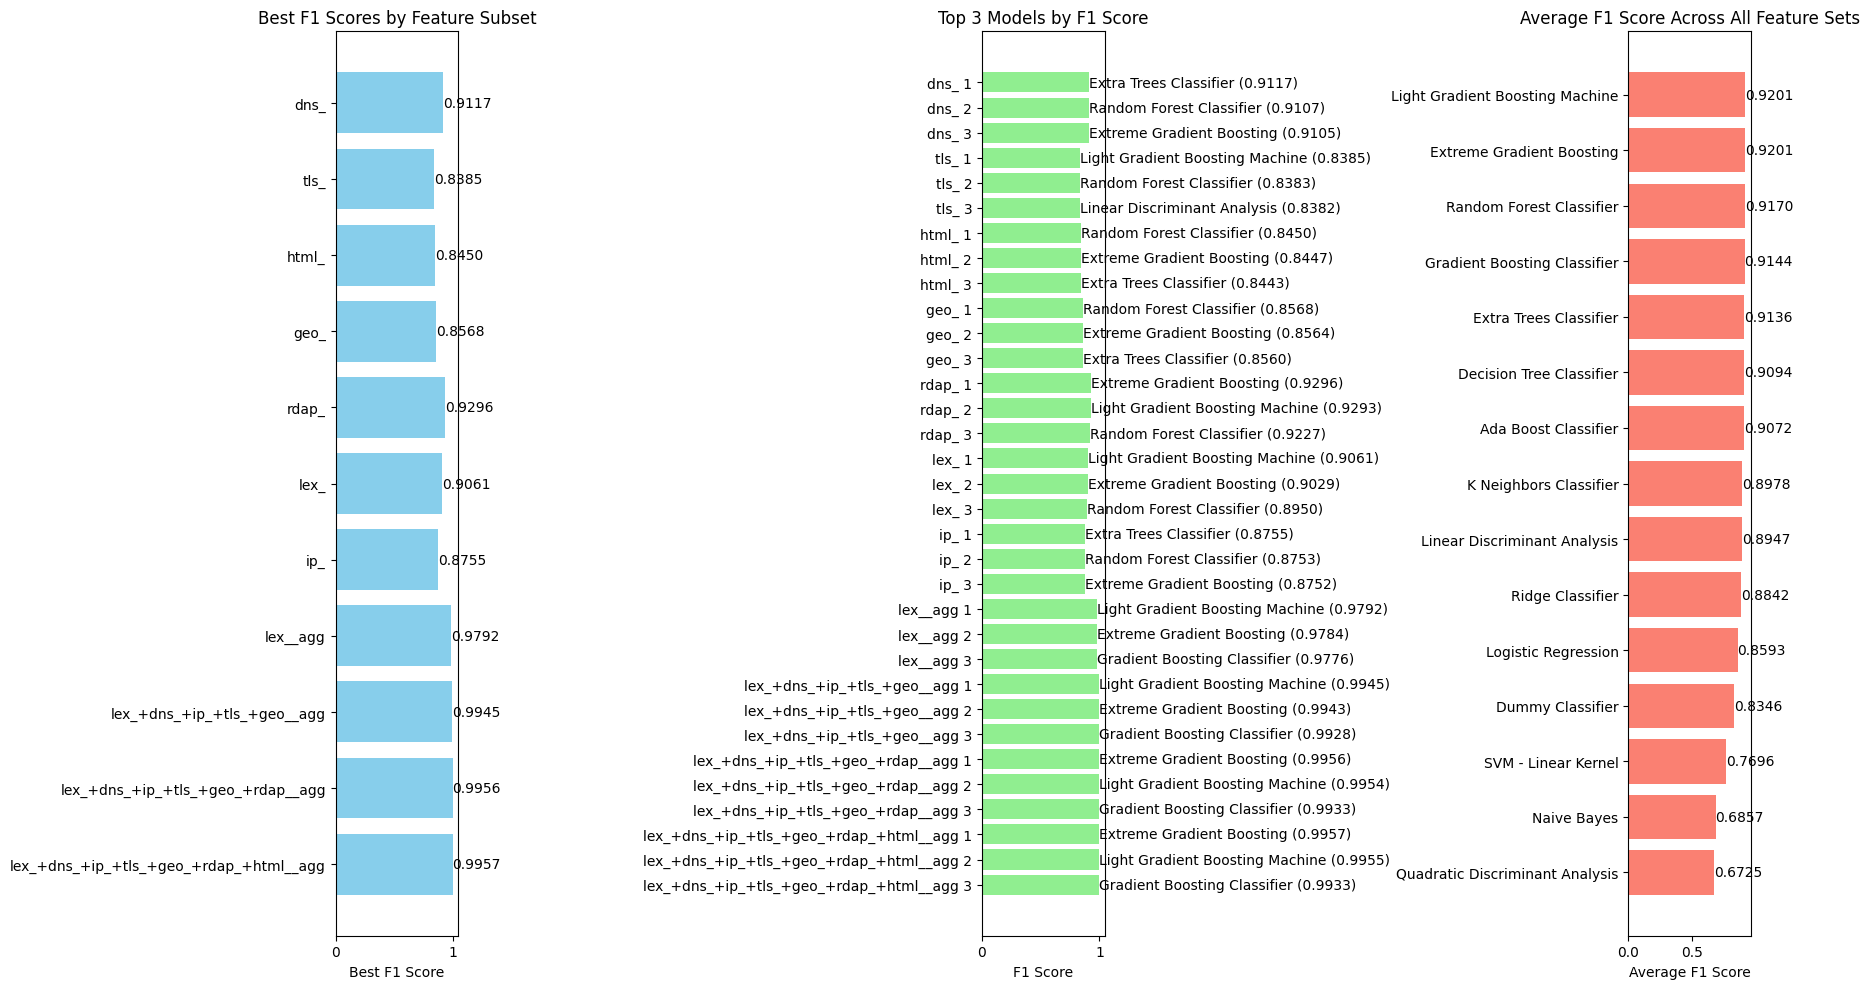

In [6]:
import matplotlib.pyplot as plt

# Extracting best F1 Scores and top models
best_f1_scores = []
model_names = []
subsets = []
top_models = {}

for prefix, grid in results_grids.items():
    # Best F1 score
    best_f1 = grid['F1'].max()
    best_f1_scores.append(best_f1)
    
    # Top 3 models
    top_3_models = grid.nlargest(3, 'F1')[['Model', 'F1']]
    top_models[prefix] = top_3_models
    model_names.append(top_3_models.iloc[0]['Model'])
    
    subsets.append(prefix)

# Initialize figure
plt.figure(figsize=(18, 10))

# Plot 1: Best F1 Scores by Feature Subset
plt.subplot(1, 3, 1)
bars = plt.barh(subsets, best_f1_scores, color='skyblue')
plt.xlabel('Best F1 Score')
plt.title('Best F1 Scores by Feature Subset')
plt.gca().invert_yaxis()
# Annotate exact F1 scores
for bar, score in zip(bars, best_f1_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

# Plot 2: Top Three Models for each Feature Subset
plt.subplot(1, 3, 2)
for i, (prefix, top_3) in enumerate(top_models.items()):
    for j, (index, row) in enumerate(top_3.iterrows()):
        plt.barh(f'{prefix} {j+1}', row['F1'], color='lightgreen')
        plt.text(row['F1'], i * 3 + j, f'{row["Model"]} ({row["F1"]:.4f})', va='center')
plt.title('Top 3 Models by F1 Score')
plt.xlabel('F1 Score')
plt.gca().invert_yaxis()

# Plot 3: Ranking of Models Across All Feature Sets
model_rankings = pd.concat([grid[['Model', 'F1']] for grid in results_grids.values()])
mean_f1_by_model = model_rankings.groupby('Model')['F1'].mean().sort_values(ascending=True)
plt.subplot(1, 3, 3)
bars = plt.barh(mean_f1_by_model.index, mean_f1_by_model, color='salmon')
plt.title('Average F1 Score Across All Feature Sets')
plt.xlabel('Average F1 Score')
# Annotate exact average F1 scores
for bar, score in zip(bars, mean_f1_by_model):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()



# TUNE MODELS

In [ ]:
from pycaret.classification import *
import pandas as pd

def tune_and_stack_all_models():
    # Dictionary to store tuned models and their F1 scores for each subset
    all_tuned_models = {}
    all_f1_scores = {}

    # Iterate over each subset in subset_dfs
    for subset_name, subset_df in subset_dfs.items():
        print(f"\n🔍 Processing subset: {subset_name}")

        # PyCaret Setup
        clf = setup(subset_df, target='label', session_id=123, log_experiment=False, experiment_name=f'ensemble_tune_{subset_name}', index=False, use_gpu=True)

        # Retrieve top models stored for the subset
        top_models = top3_models[subset_name]

        # Blending the top models
        blended_model = blend_models(estimator_list=top_models)

        # Tuning the blended model
        tuned_model = tune_model(blended_model, optimize='F1', n_iter=10)

        # Retrieve F1 score of the tuned model
        f1_score = pull().iloc[-1]['F1']

        # Saving the tuned model and F1 score
        model_name = f'tuned_{subset_name}'
        saved_model = save_model(tuned_model, model_name)
        all_tuned_models[subset_name] = saved_model
        all_f1_scores[subset_name] = f1_score

        print(f"✅ Tuned and saved model for '{subset_name}' with F1 Score: {f1_score:.4f}")

    # Save all_tuned_models and their F1 scores to pickle
    save_to_pickle(all_tuned_models, 'all_tuned_models.pickle')
    save_to_pickle(all_f1_scores, 'all_tuned_f1_scores.pickle')

    print("\n🔗 Final stacked model across all subsets created and saved.")
    return all_tuned_models

# Execute the function
final_model = tune_and_stack_all_models()


Data saved to all_tuned_models.pickle.

🔗 Final stacked model across all subsets created and saved as 'final_stacked_model'.


In [ ]:
# combine all models into one ensemble model
from pycaret.classification import *

def combine_all_models():
    # load models from pickle

    
    final_stacked_model = stack_models(estimator_list=list(load_from_pickle('all_tuned_models.pickle').values()))

    # Saving the final stacked model
    save_model(final_stacked_model, 'final_stacked_model')